#Descrizione

In questo notebook viene implementata una rete neurale Vanilla.

Sono implementati 2 modelli, uno con immagini interpolate nella dimensione 64x64 e l'altro con immagini interpolate nella dimensione 596x64.

Sono presenti grafici circa la validation accuracy, validation loss, confusion matrix e grafici che analizzano gli errori di classificazione: per lista offuscamento applicata, per lista offuscamento ignorando l'ordine degli offuscamenti, per classe e per offuscamento applicato in percentuale al numero di offuscamenti effettuati.

In fondo al notebook vi è un grafo che mostra la validation accuracy dei due modelli a confronto.

Parametri:

database_scelto = '14k', interpolato.

batch_size = 1024

num_units1 = 141

num_units2 = 94

channels = 1

n_epochs = 100

patience = 10

##64x64
64x64: Accuratezza 86,79%, 48 epochs, 33.75s.
* ('Flatten-RandomFuns-Split', 25)
* ('EncodeLiterals-InitOpaque-Split', 23)
* ('EncodeLiterals-InitEntropy-InitOpaque', 19)

#596x64
596x64: Accuratezza 89,01%, 94 epochs, 483.18s.
* ('Flatten-RandomFuns-Split', 33)
* ('EncodeLiterals-InitOpaque-Split', 31)
* ('EncodeLiterals-Flatten-Split', 18)

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import tensorflow as tf
from tensorflow import keras as ks


import numpy as np
import pandas as pd

import time
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
'''
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers import Conv2D
'''
print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Parametri modello 1

In [3]:
database_scelto = '14k' #or '9k' or '18k'

dim1 = 64
dim2 = 64
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

#time_steps = dim1
#n_features = dim2

n_epochs = 100
patience = 10

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

Cloning into 'NN_modules'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [6]:
import Defining_Methods as my_lib

In [7]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_interp(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

14100
START IMAGE INPUT
END IMAGE INPUT


In [8]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 1

In [9]:
modelVanilla, hist, time_callback = my_lib.modelVanilla(num_units1, num_units2, batch_size, n_classes, patience, sub_db, n_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##Risultati modello 1

In [10]:
number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)

test_accuracy = modelVanilla.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

2256/2256 [==============================] - 0s 63us/sample - loss: 0.6563 - acc: 0.8679
Total epochs 48
34.745437145233154 s


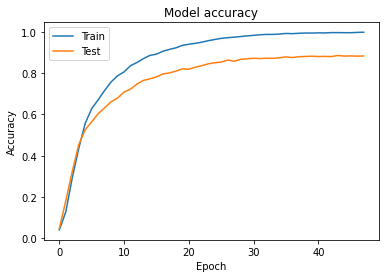

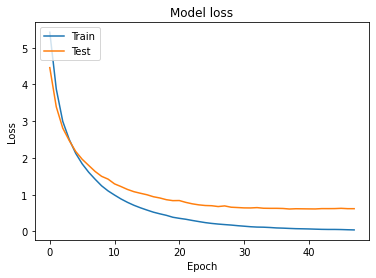

In [11]:
plt.show(my_lib.plot_model_acc(hist))
plt.show(my_lib.plot_model_loss(hist))

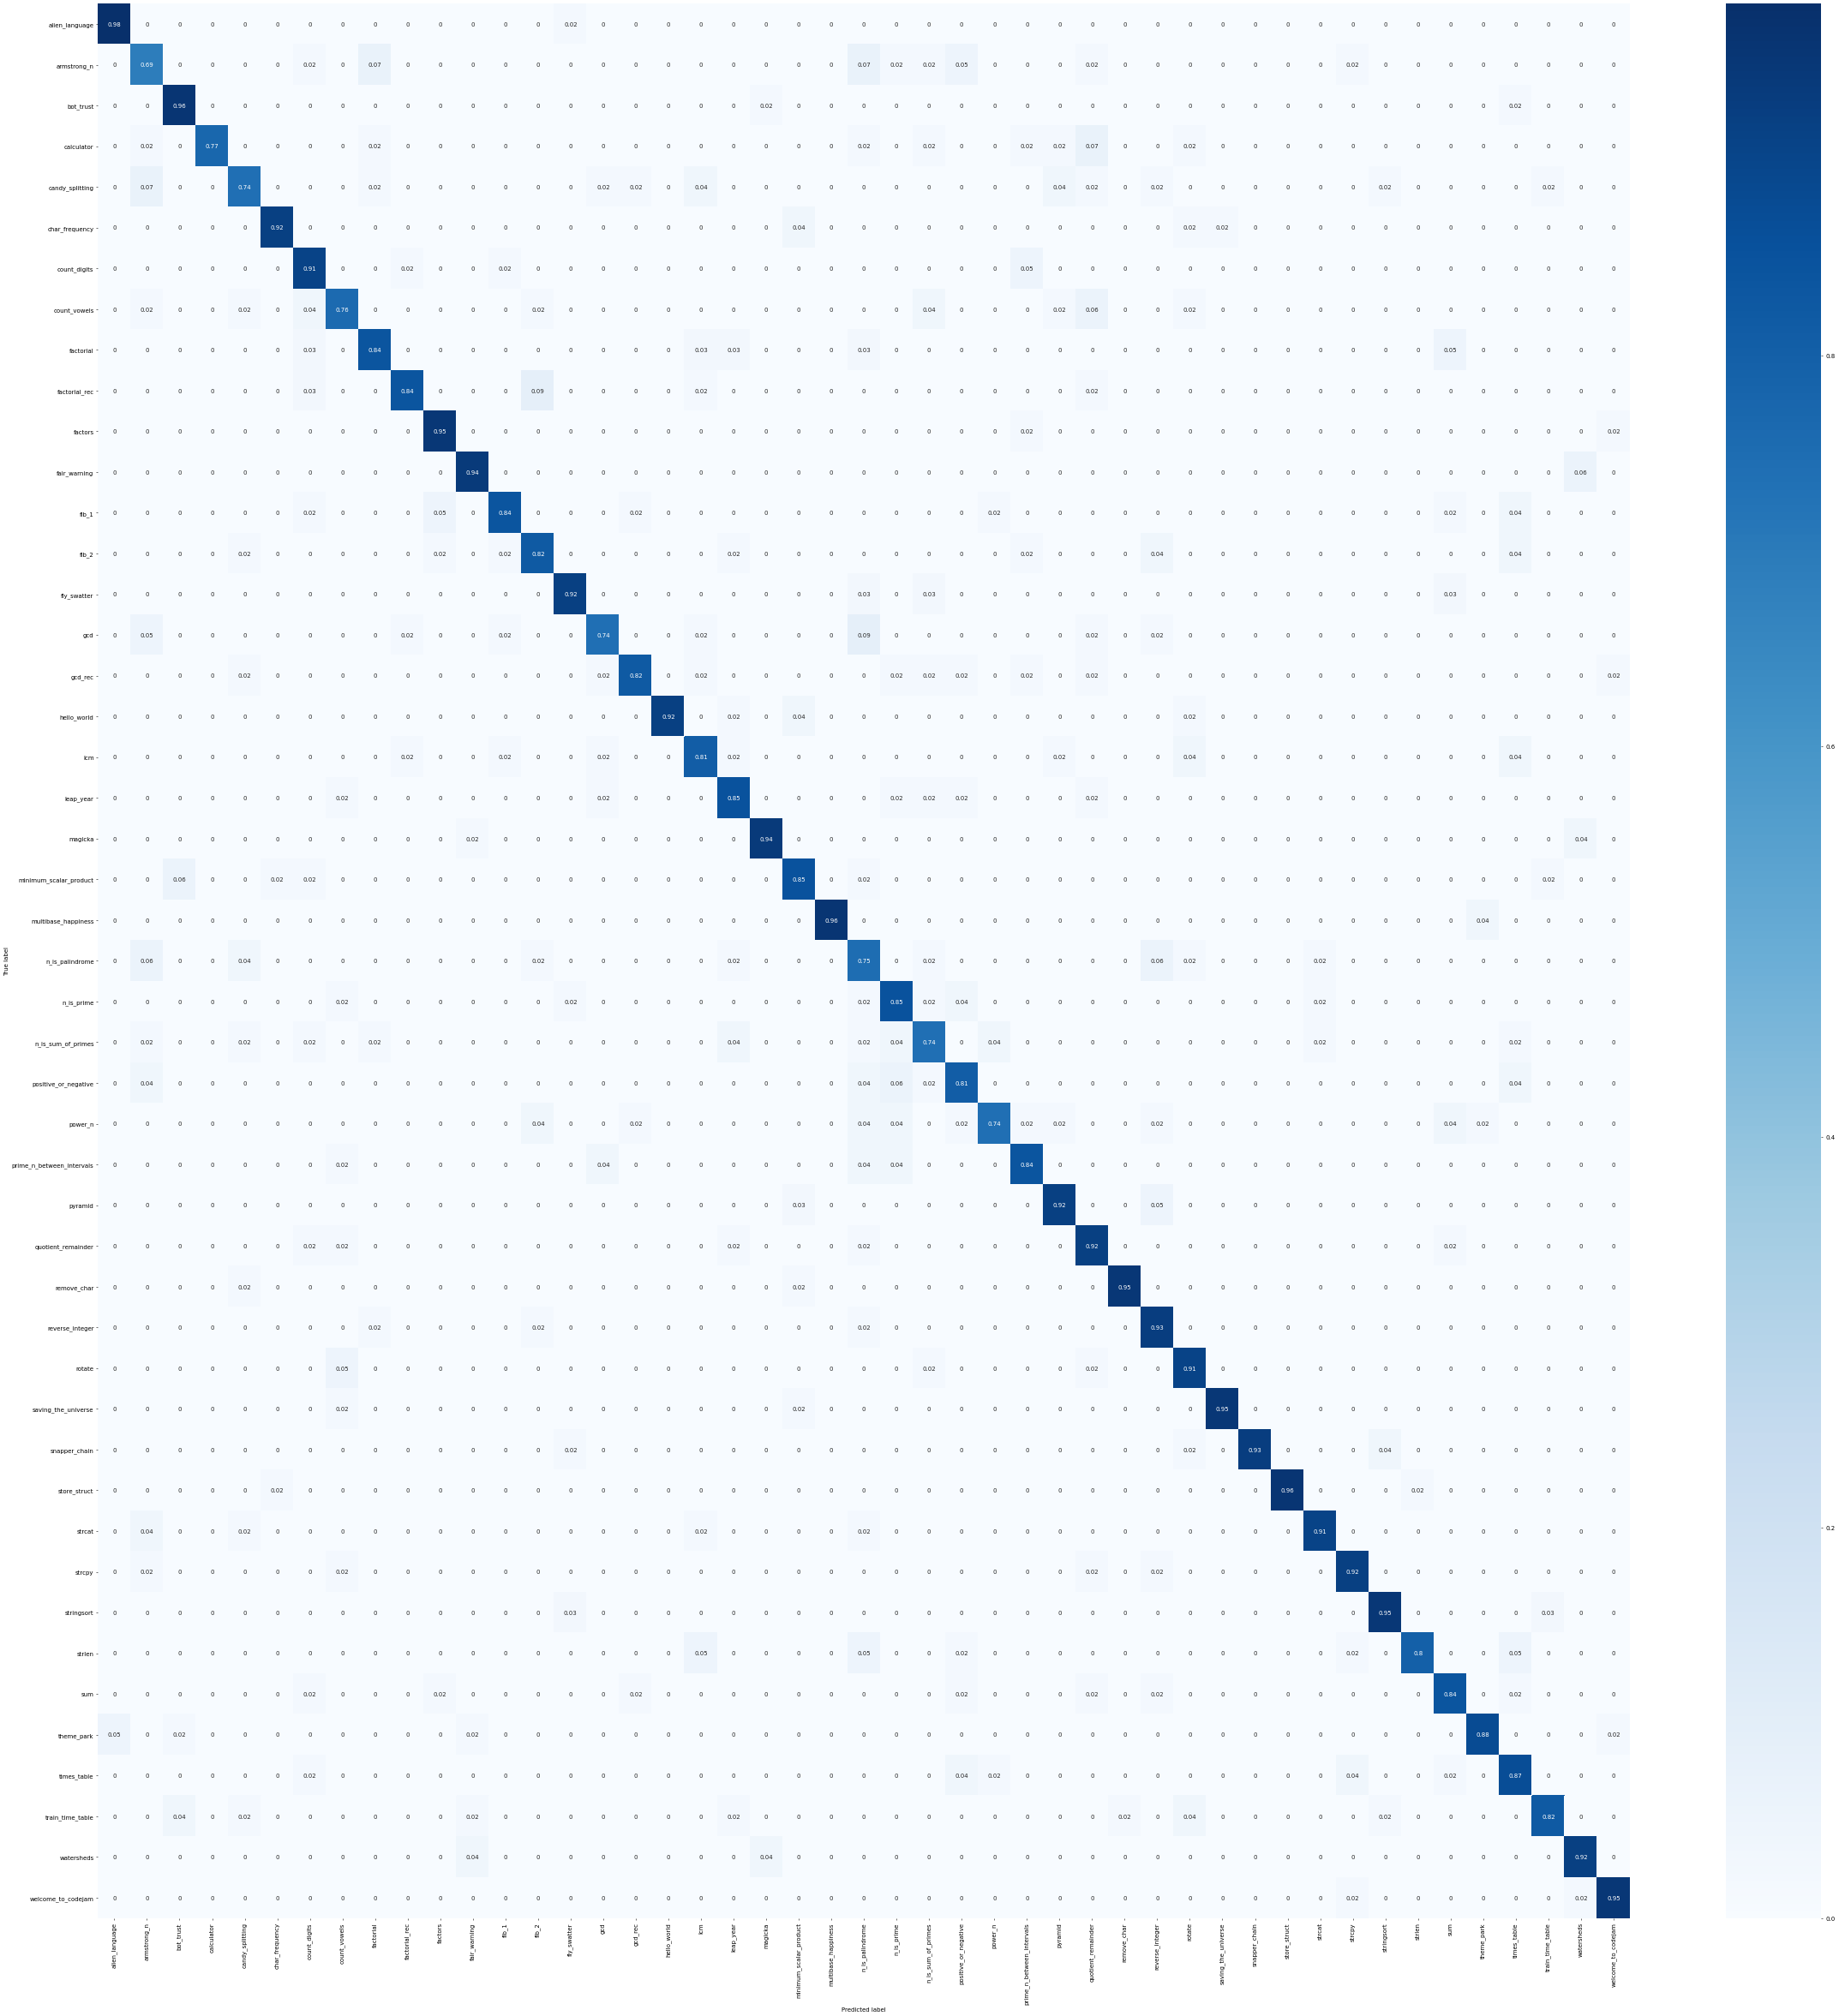

In [12]:
plt.show(my_lib.plot_conf_matrix(modelVanilla, validation_images, validation_labels_encoded, label_encoder))

Grafo degli errori focalizzato sul singolo set di offuscamento


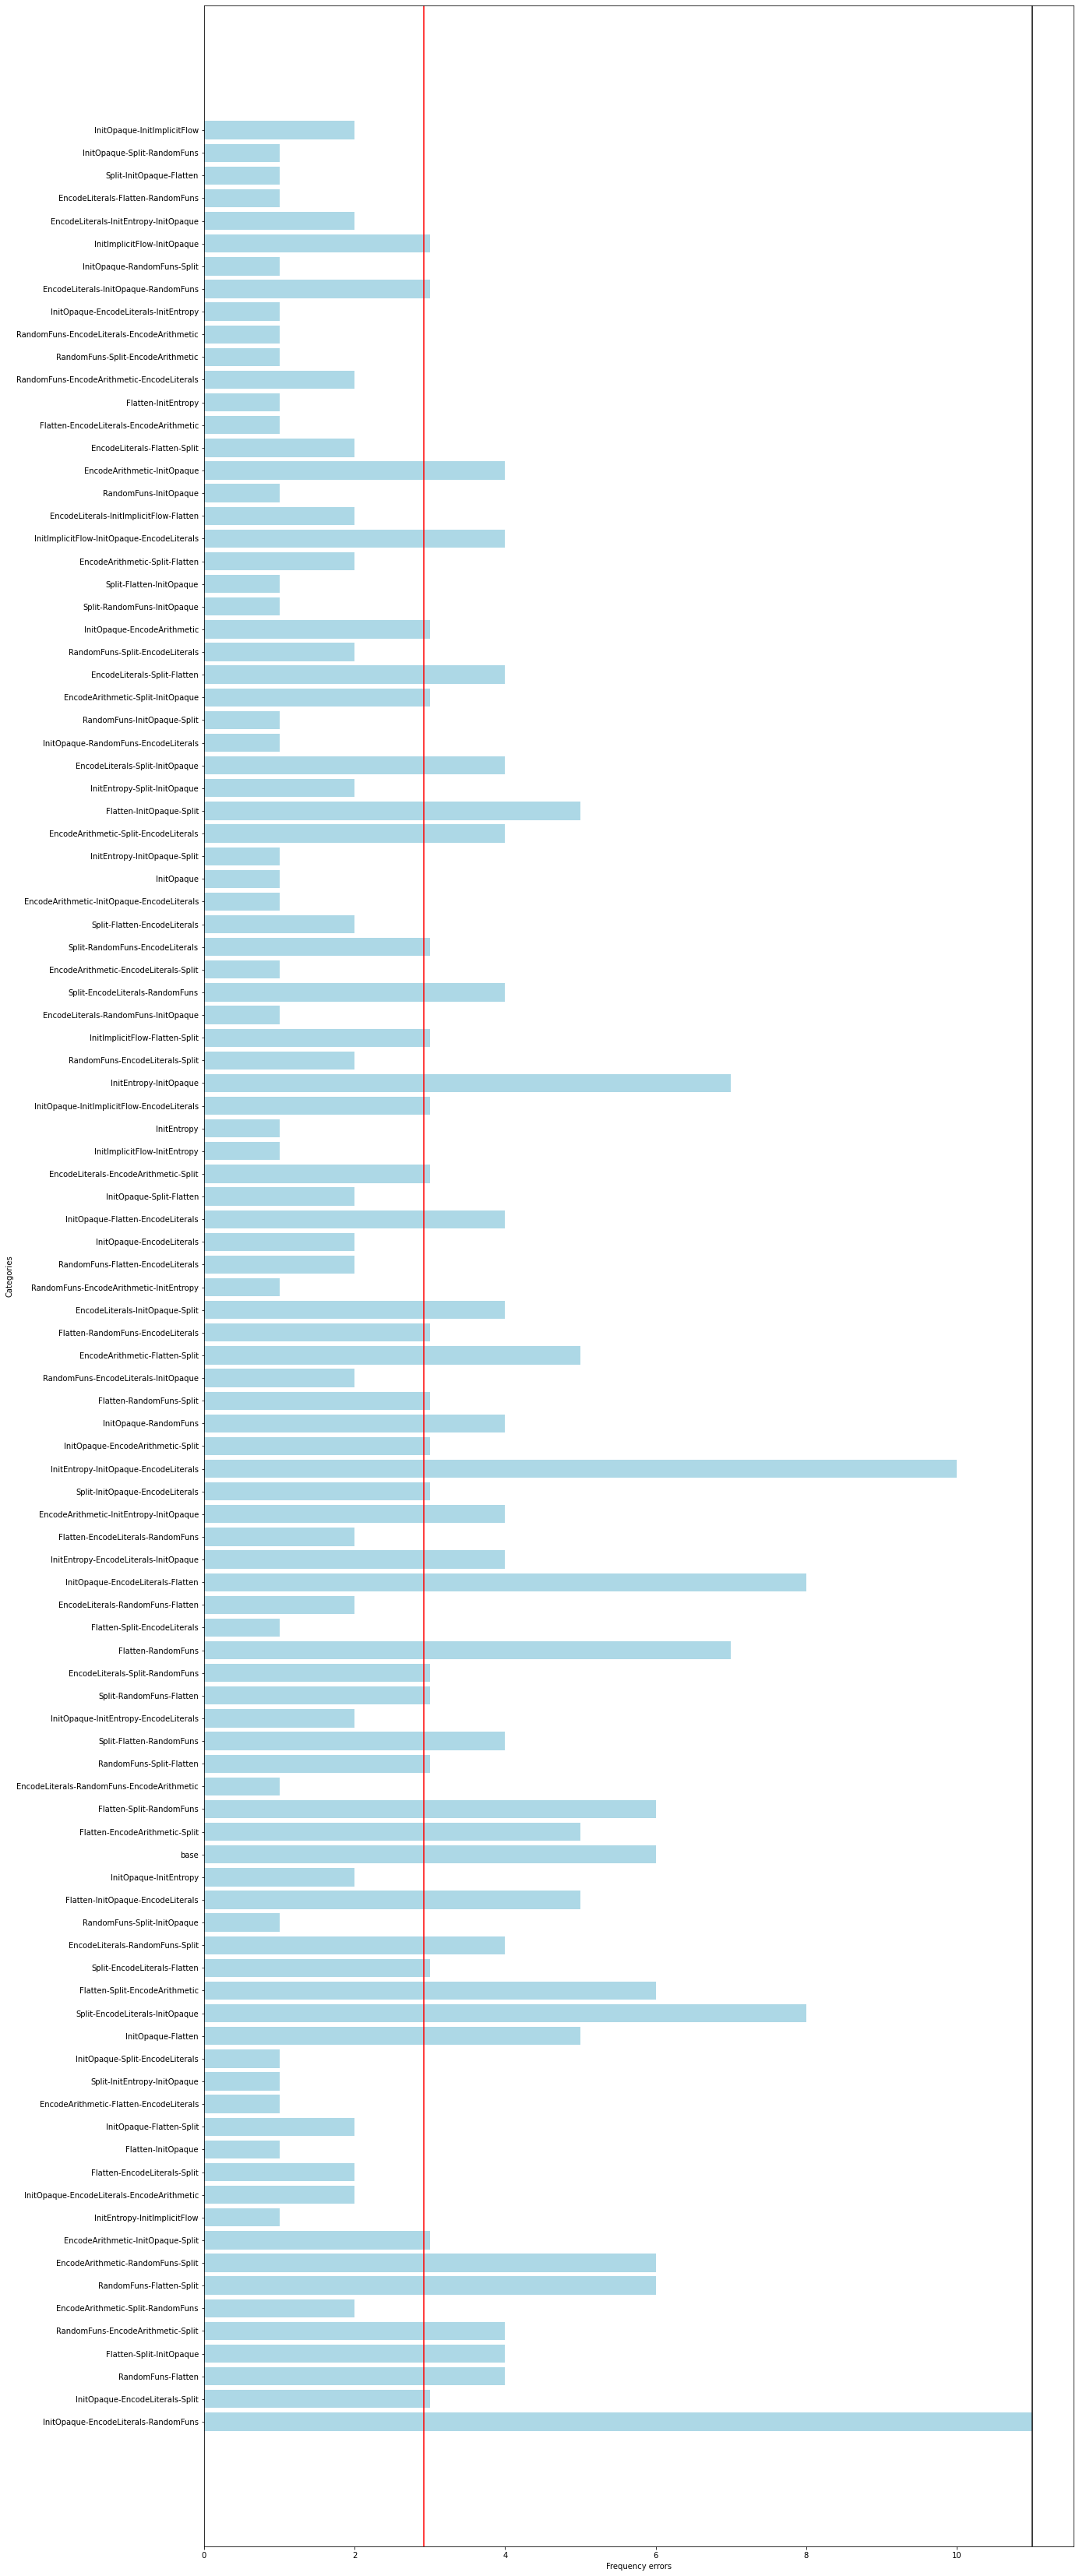


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


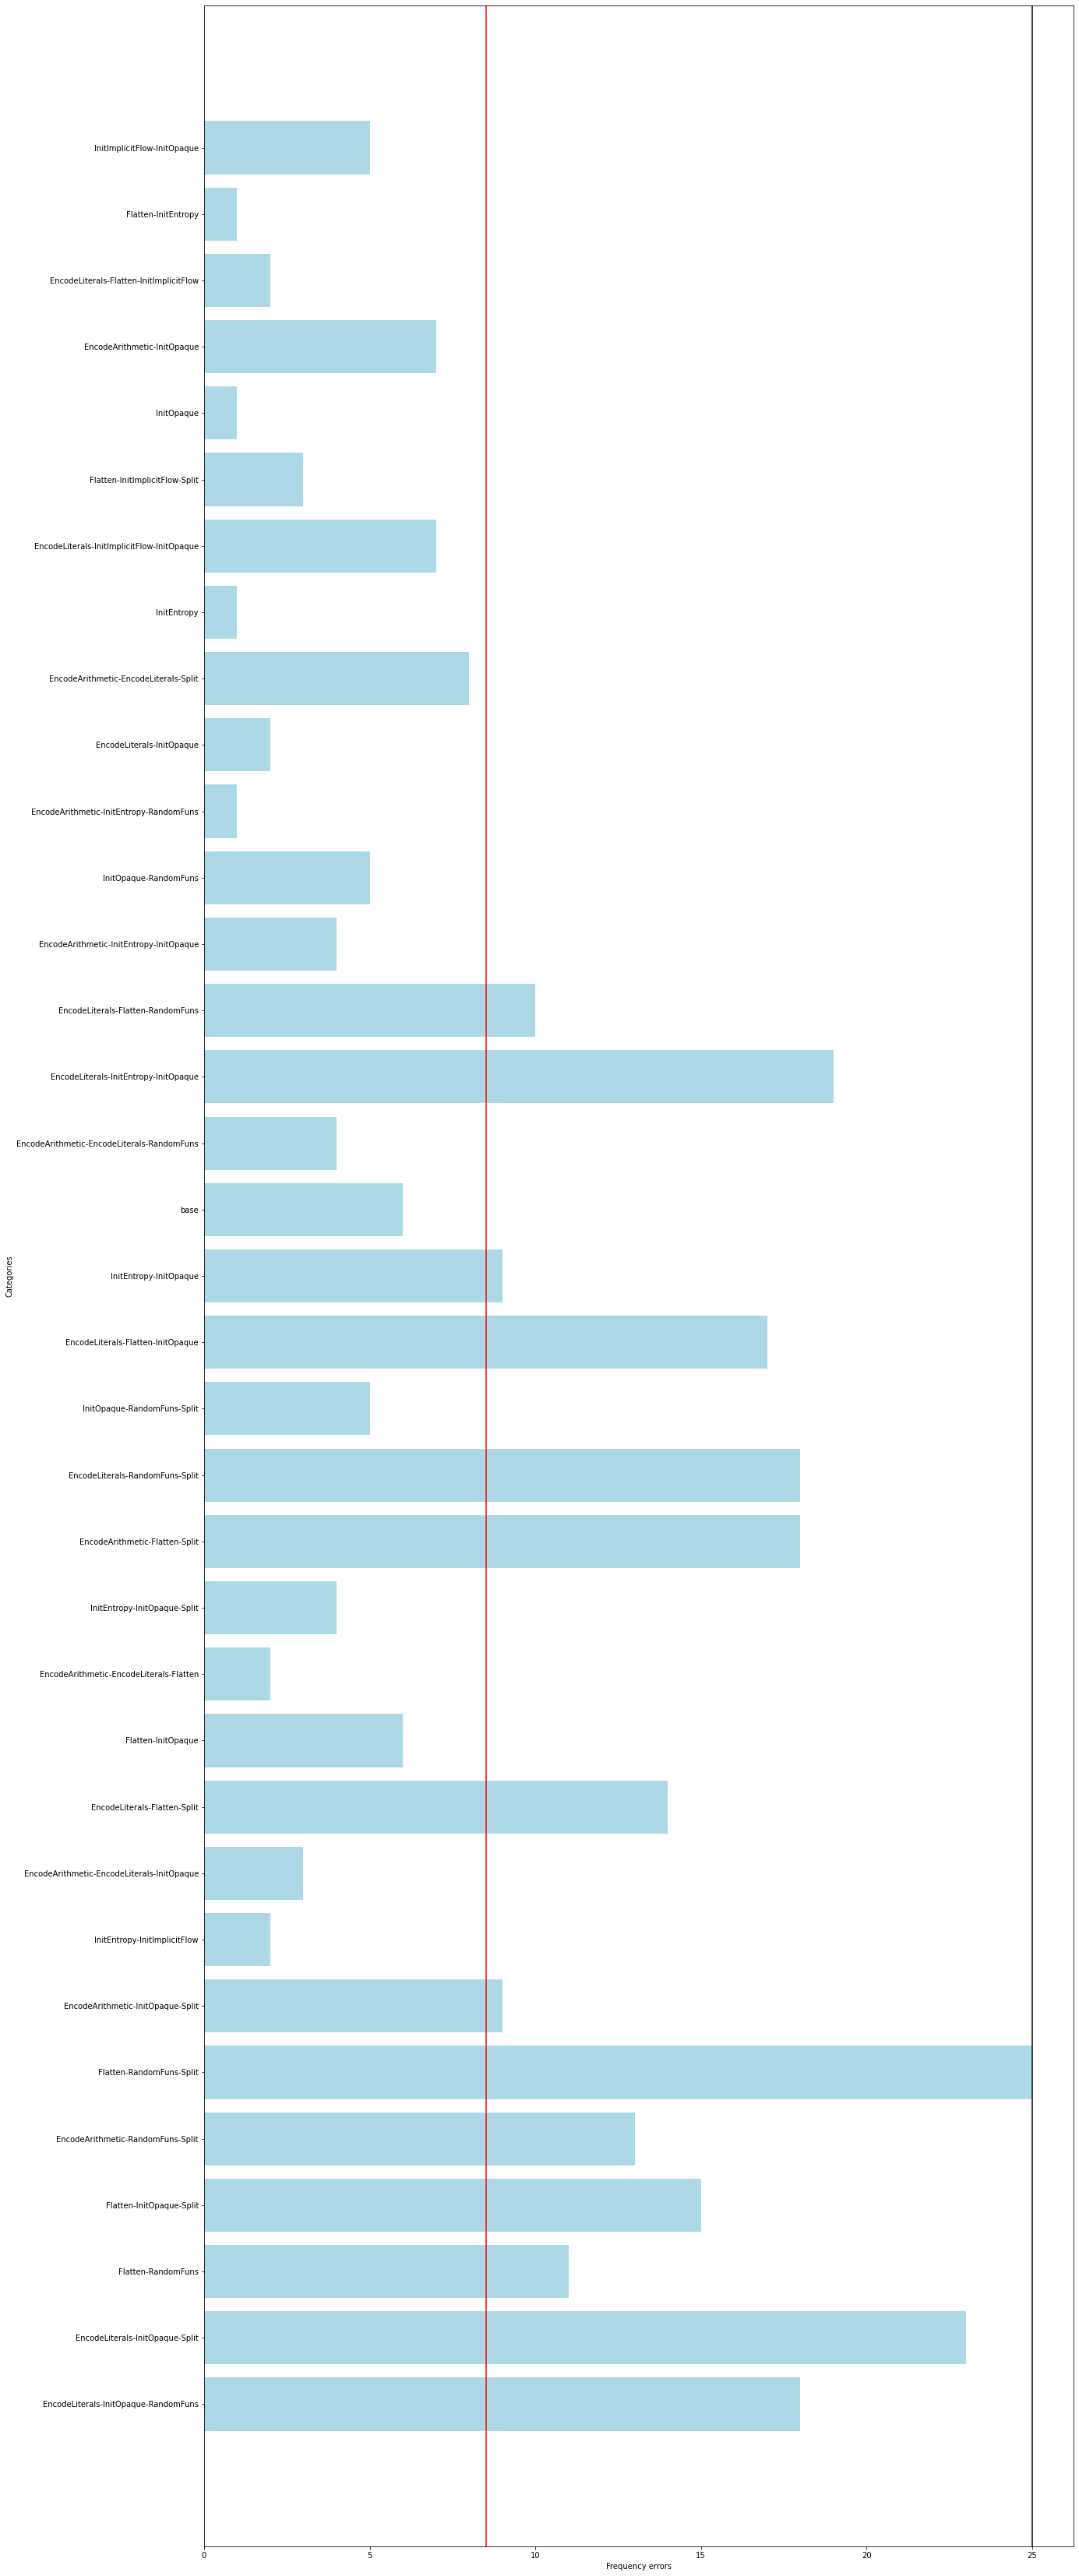


Grafo degli errori per classe


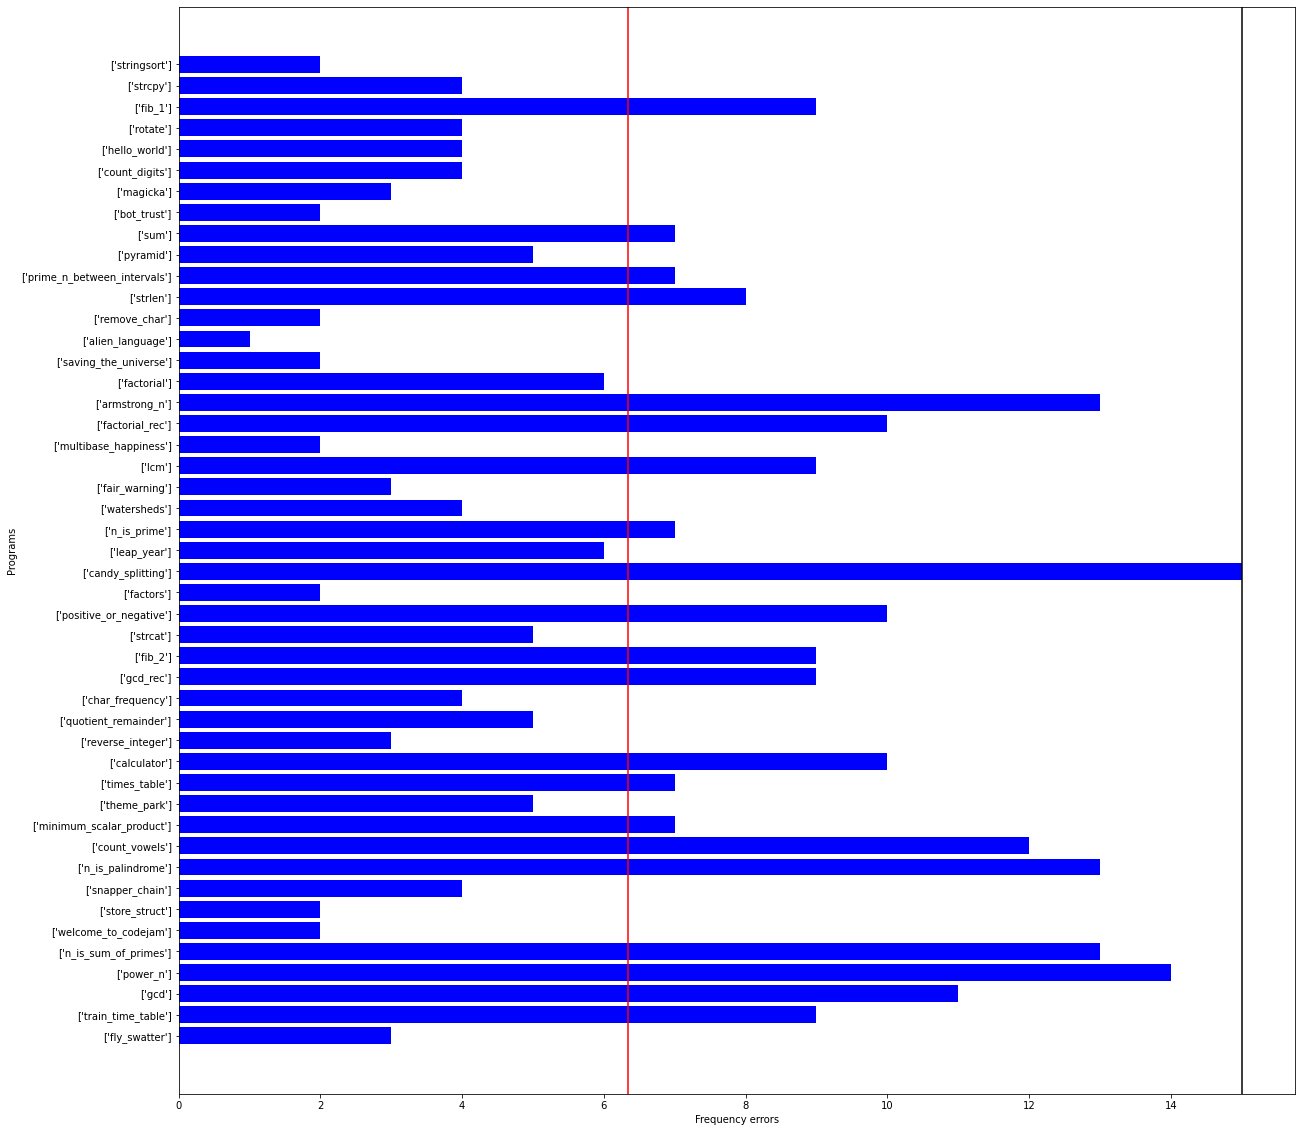


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


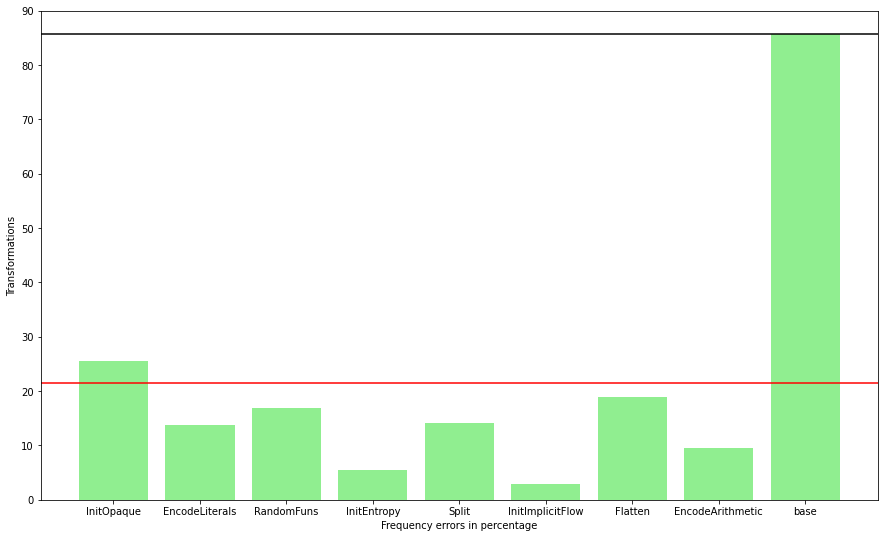

In [13]:
count_labels_err, count_obf_err, count_set_obfs, single_obf_percentage = my_lib.computing_incorrects_stats(modelVanilla, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_obf_err, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_set_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_labels_err, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))

In [14]:
#Ordina e ritorna una lista
ordered_set_obfs = count_set_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-RandomFuns-Split', 25)
('EncodeLiterals-InitOpaque-Split', 23)
('EncodeLiterals-InitEntropy-InitOpaque', 19)
('EncodeLiterals-InitOpaque-RandomFuns', 18)
('EncodeArithmetic-Flatten-Split', 18)
('EncodeLiterals-RandomFuns-Split', 18)
('EncodeLiterals-Flatten-InitOpaque', 17)
('Flatten-InitOpaque-Split', 15)
('EncodeLiterals-Flatten-Split', 14)
('EncodeArithmetic-RandomFuns-Split', 13)
('Flatten-RandomFuns', 11)
('EncodeLiterals-Flatten-RandomFuns', 10)
('EncodeArithmetic-InitOpaque-Split', 9)
('InitEntropy-InitOpaque', 9)
('EncodeArithmetic-EncodeLiterals-Split', 8)
('EncodeLiterals-InitImplicitFlow-InitOpaque', 7)
('EncodeArithmetic-InitOpaque', 7)
('Flatten-InitOpaque', 6)
('base', 6)
('InitOpaque-RandomFuns-Split', 5)
('InitOpaque-RandomFuns', 5)
('InitImplicitFlow-InitOpaque', 5)
('InitEntropy-InitOpaque-Split', 4)
('EncodeArithmetic-EncodeLiterals-RandomFuns', 4)
('EncodeArithmetic-InitEntropy-InitOpaque', 4)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 3)
('Flatten-Ini

#Parametri modello 2

In [15]:
database_scelto = '14k' #or '9k' or '18k'

dim1 = 596
dim2 = 64
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

#time_steps = dim1
#n_features = dim2

n_epochs = 100
patience = 10

In [16]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_interp(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

14100
START IMAGE INPUT
END IMAGE INPUT


In [17]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 2

In [18]:
modelVanilla2, hist2, time_callback2 = my_lib.modelVanilla(num_units1, num_units2, batch_size, n_classes, patience, sub_db, n_epochs)

##Risultati modello 2

In [19]:
number_of_epochs_it_ran = len(hist2.history['loss'])

time_per_epoch = time_callback2.times
total_time = sum(time_per_epoch)

test_accuracy = modelVanilla2.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

2256/2256 [==============================] - 1s 367us/sample - loss: 0.5704 - acc: 0.8901
Total epochs 94
483.1835880279541 s


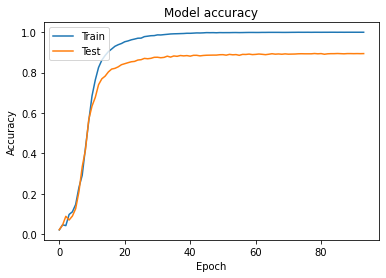

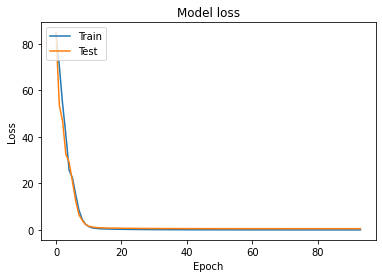

In [20]:
plt.show(my_lib.plot_model_acc(hist2))
plt.show(my_lib.plot_model_loss(hist2))

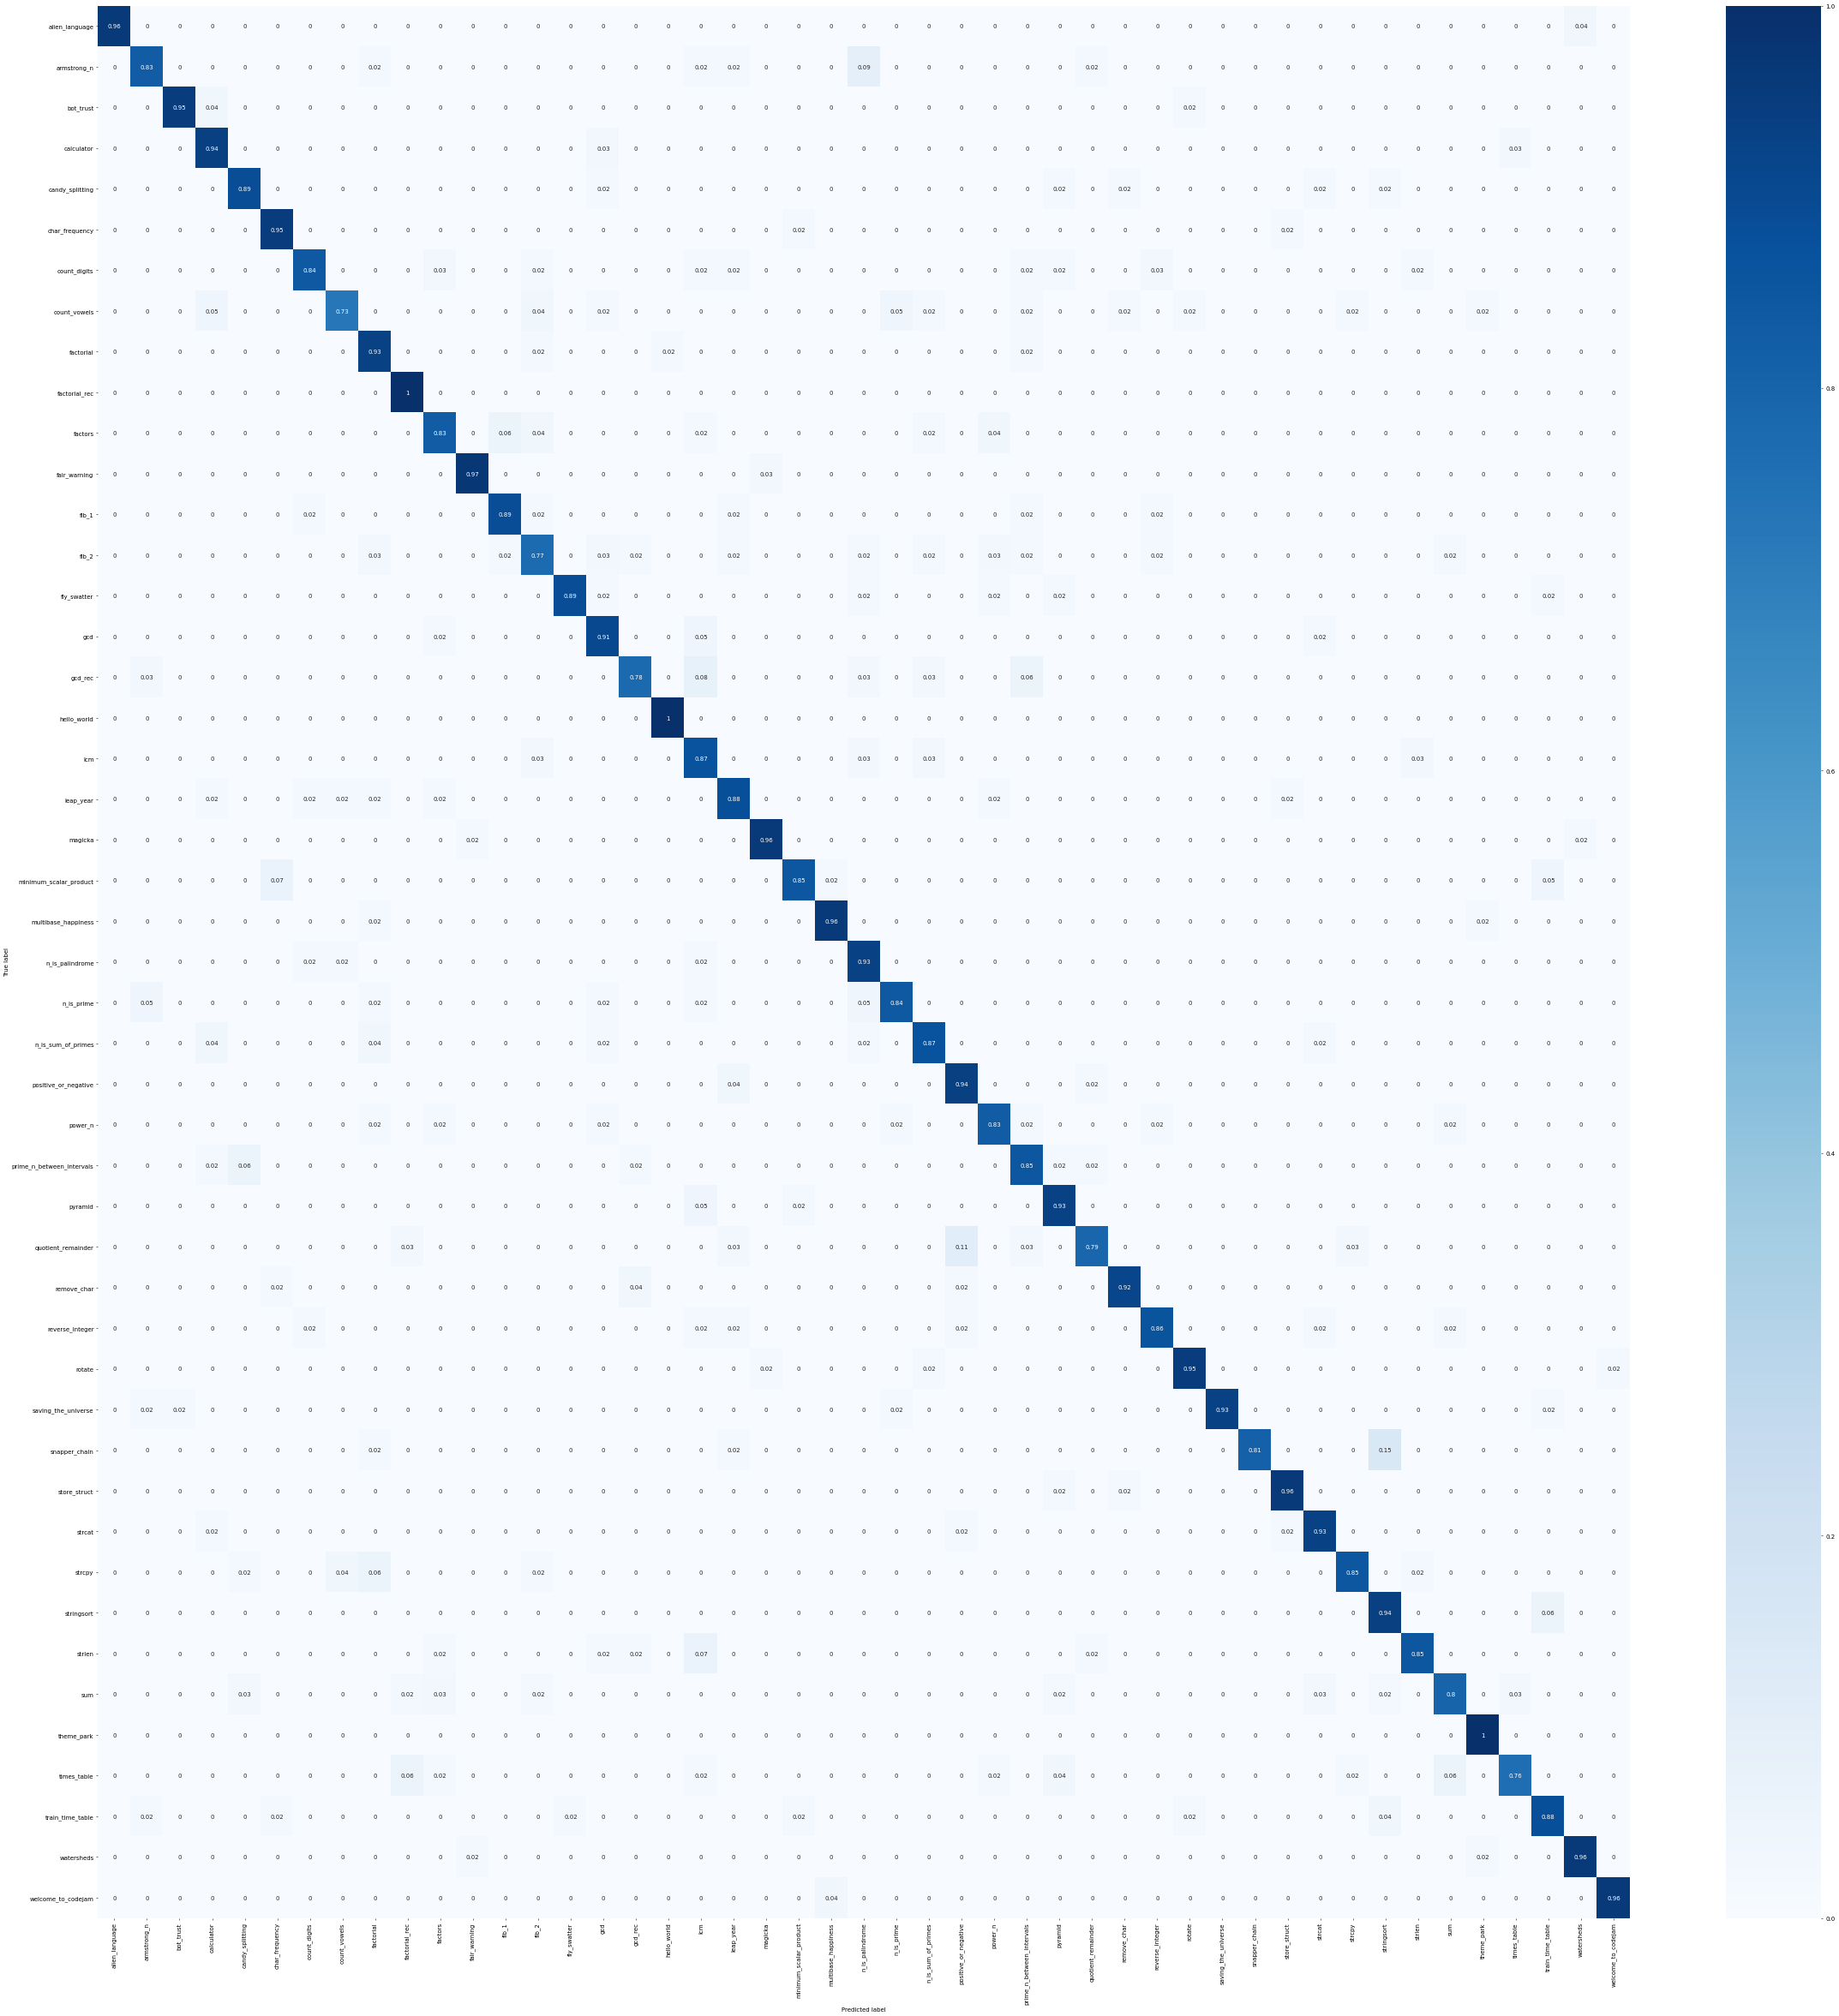

In [21]:
plt.show(my_lib.plot_conf_matrix(modelVanilla2, validation_images, validation_labels_encoded, label_encoder))

Grafo degli errori focalizzato sul singolo set di offuscamento


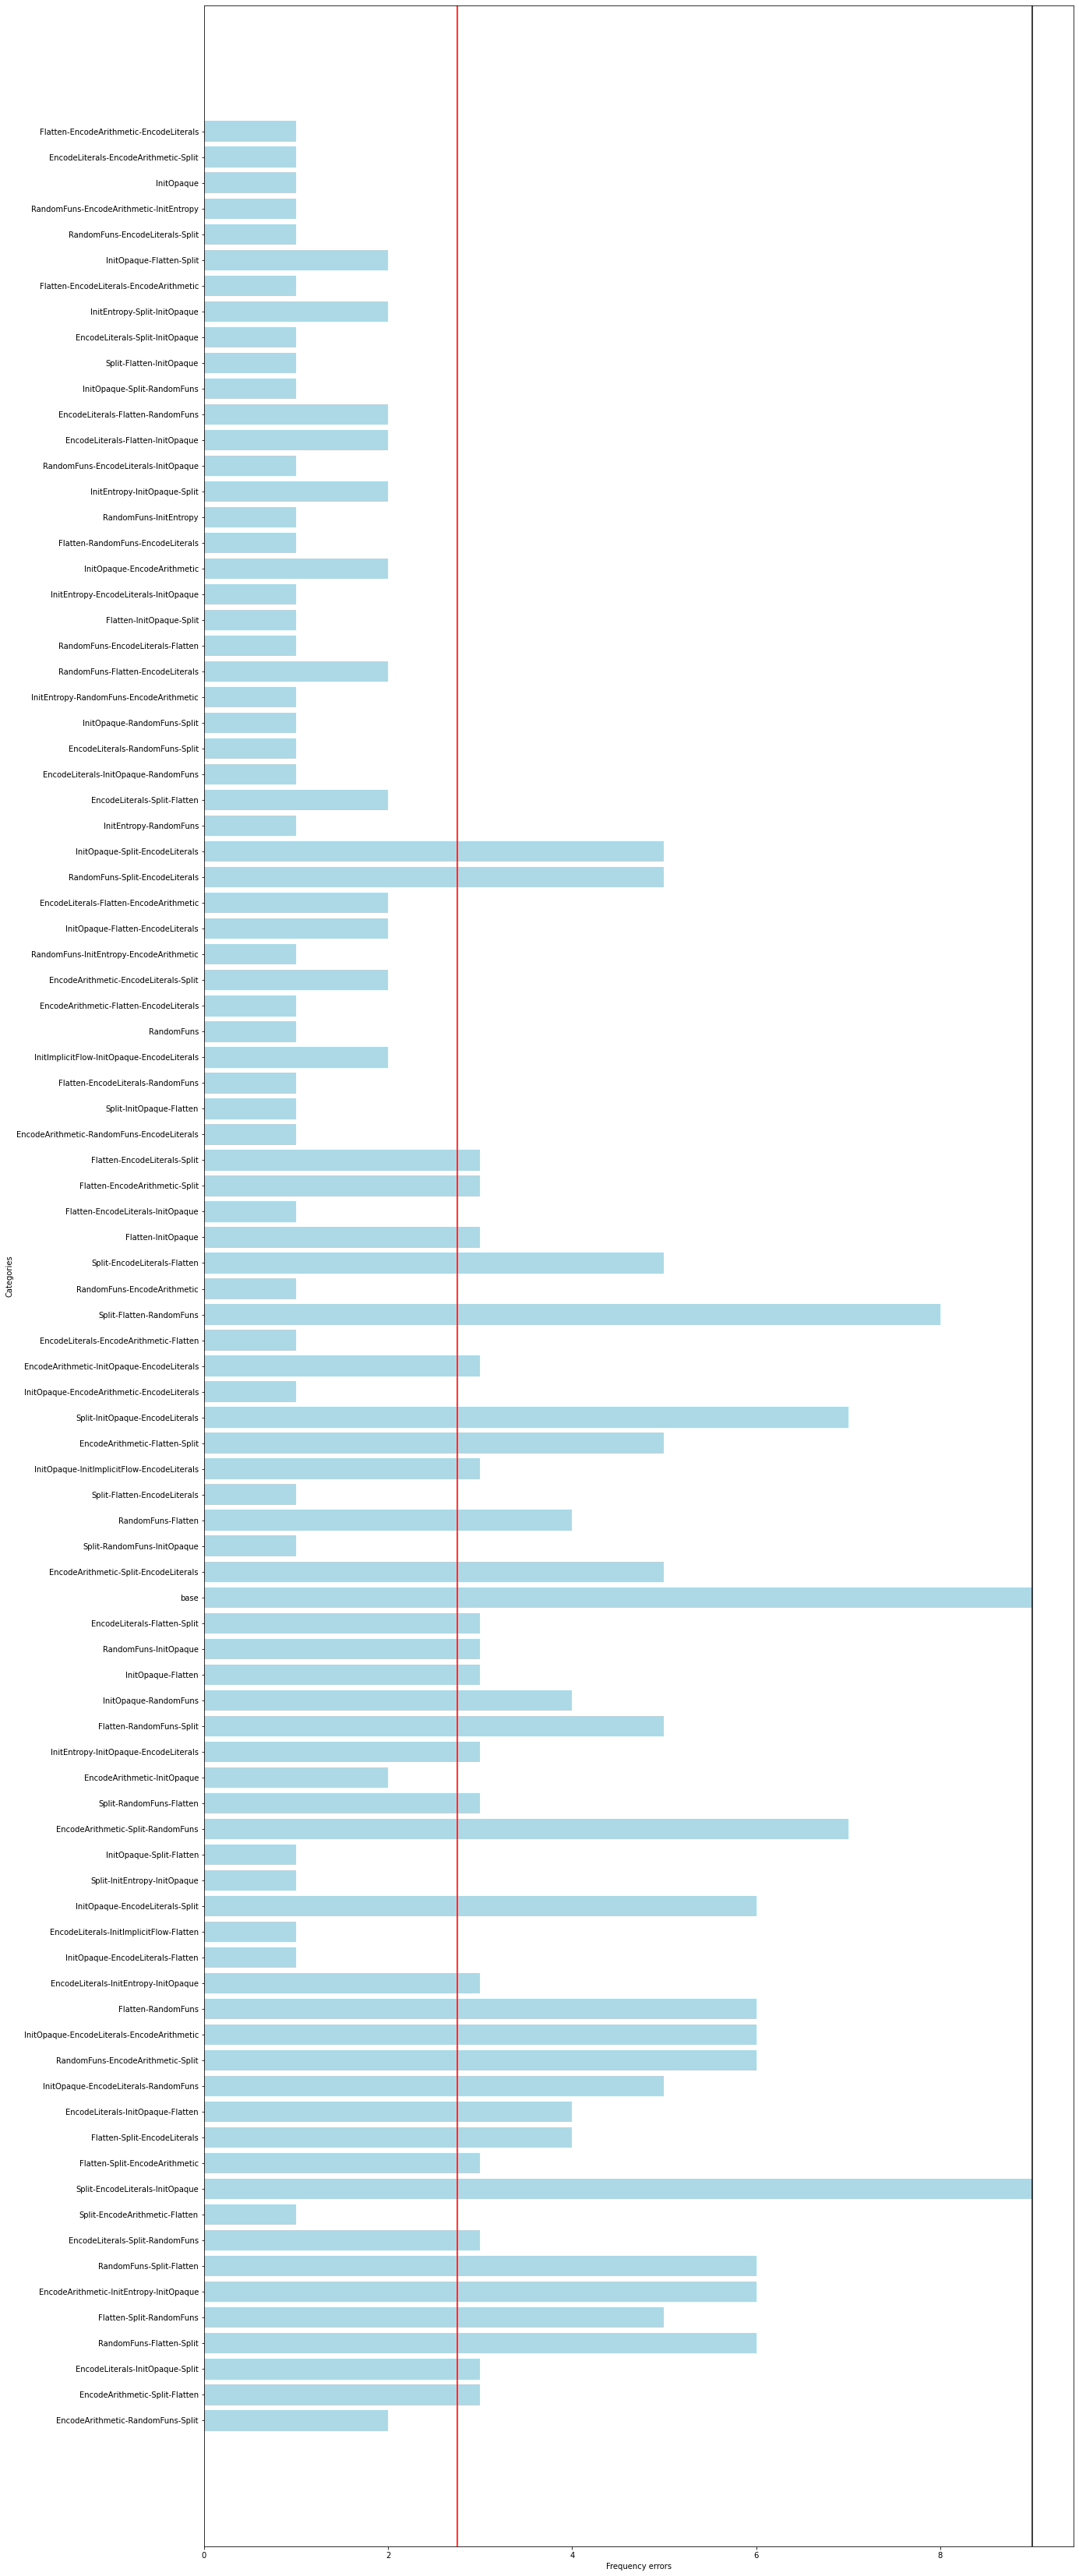


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


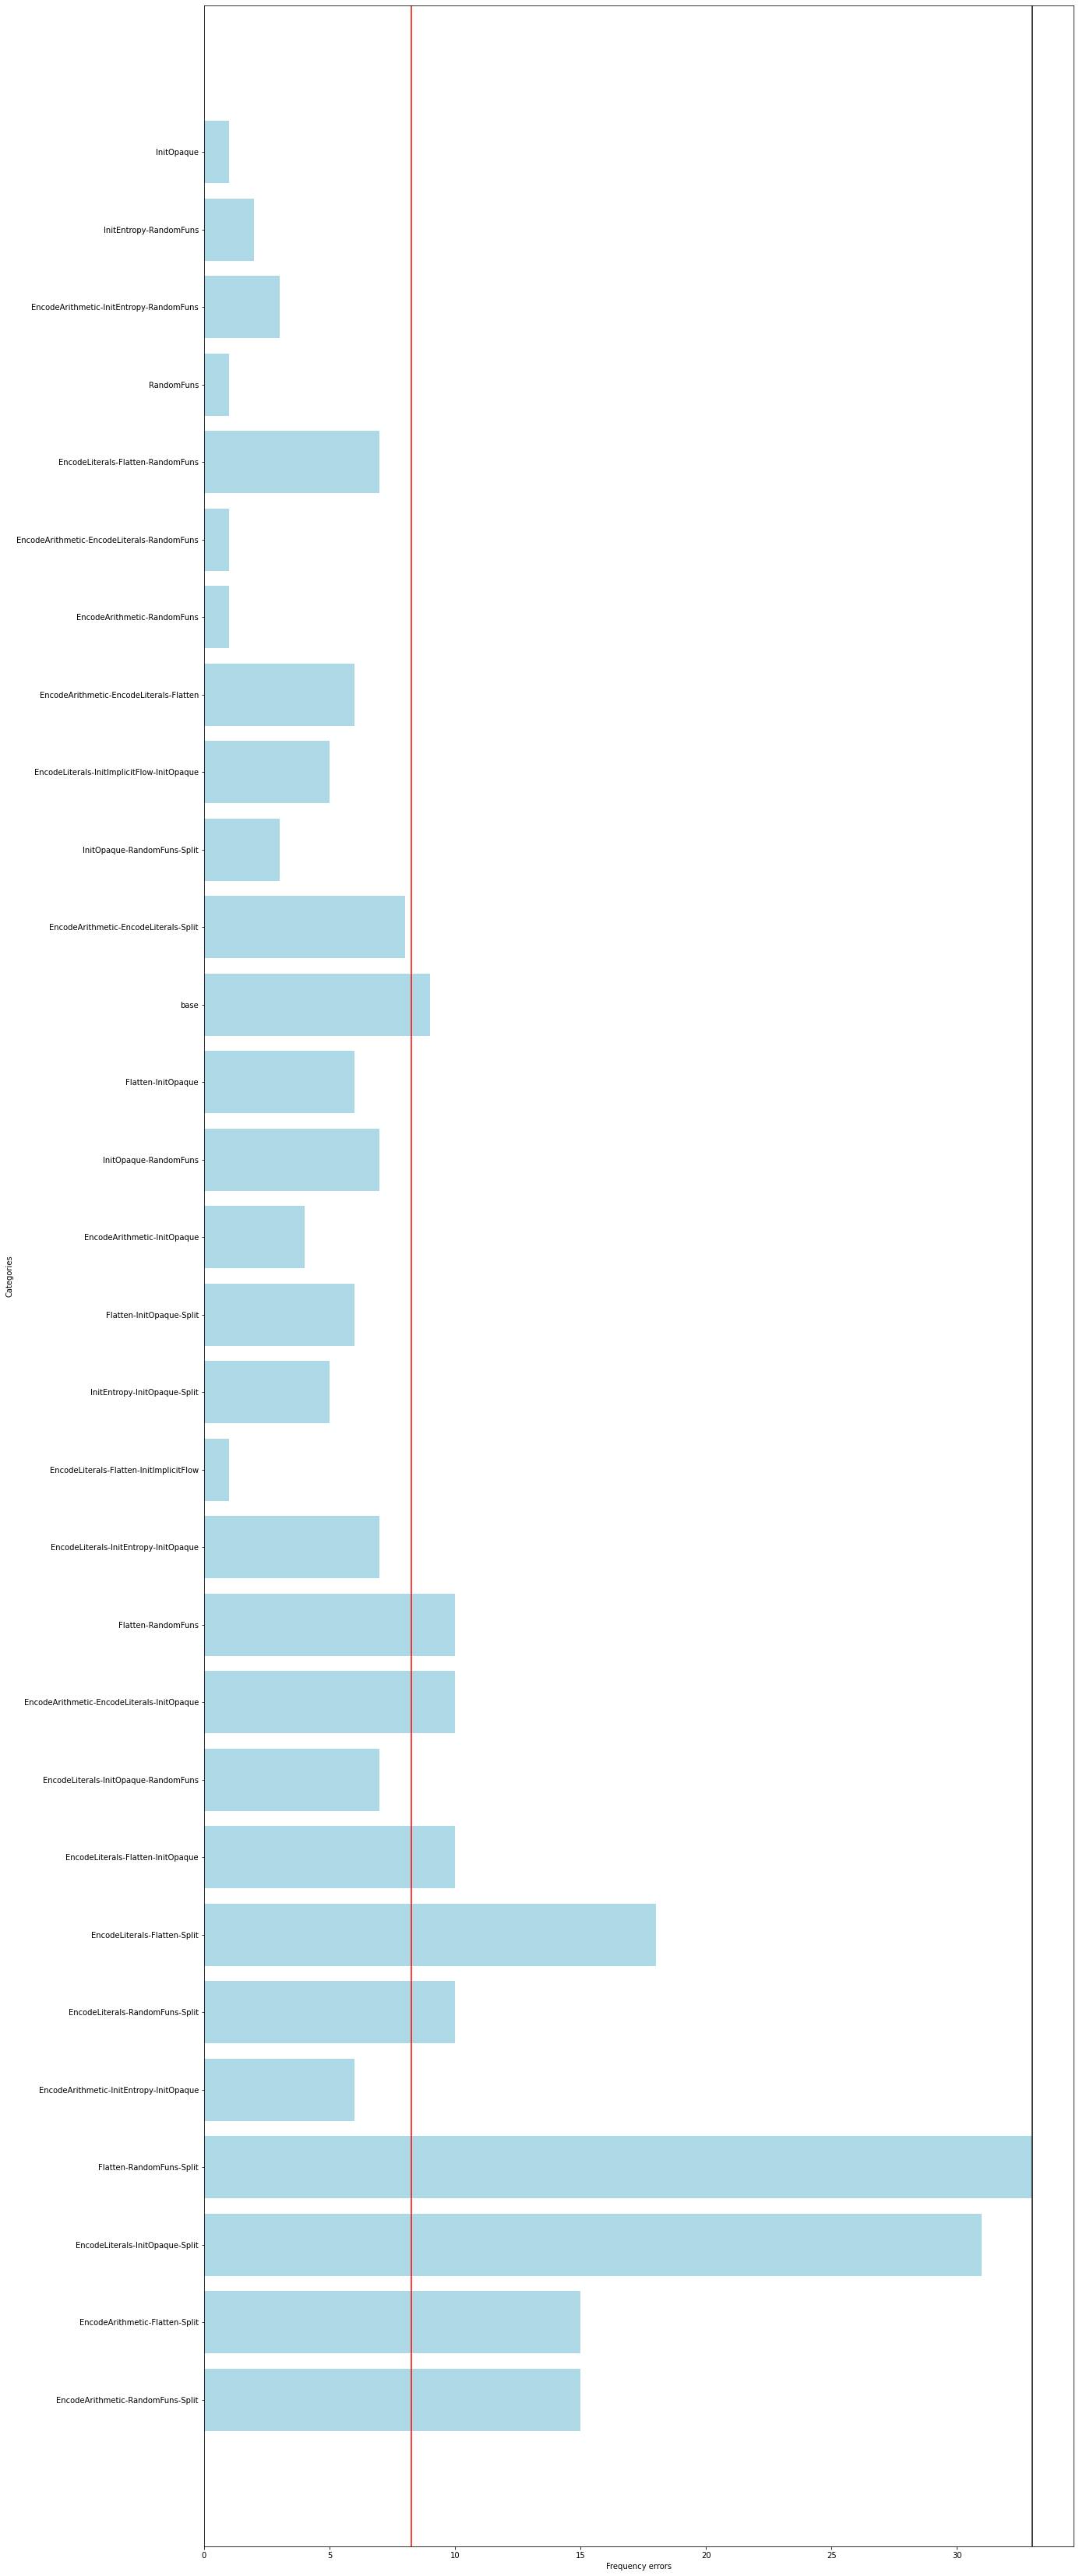


Grafo degli errori per classe


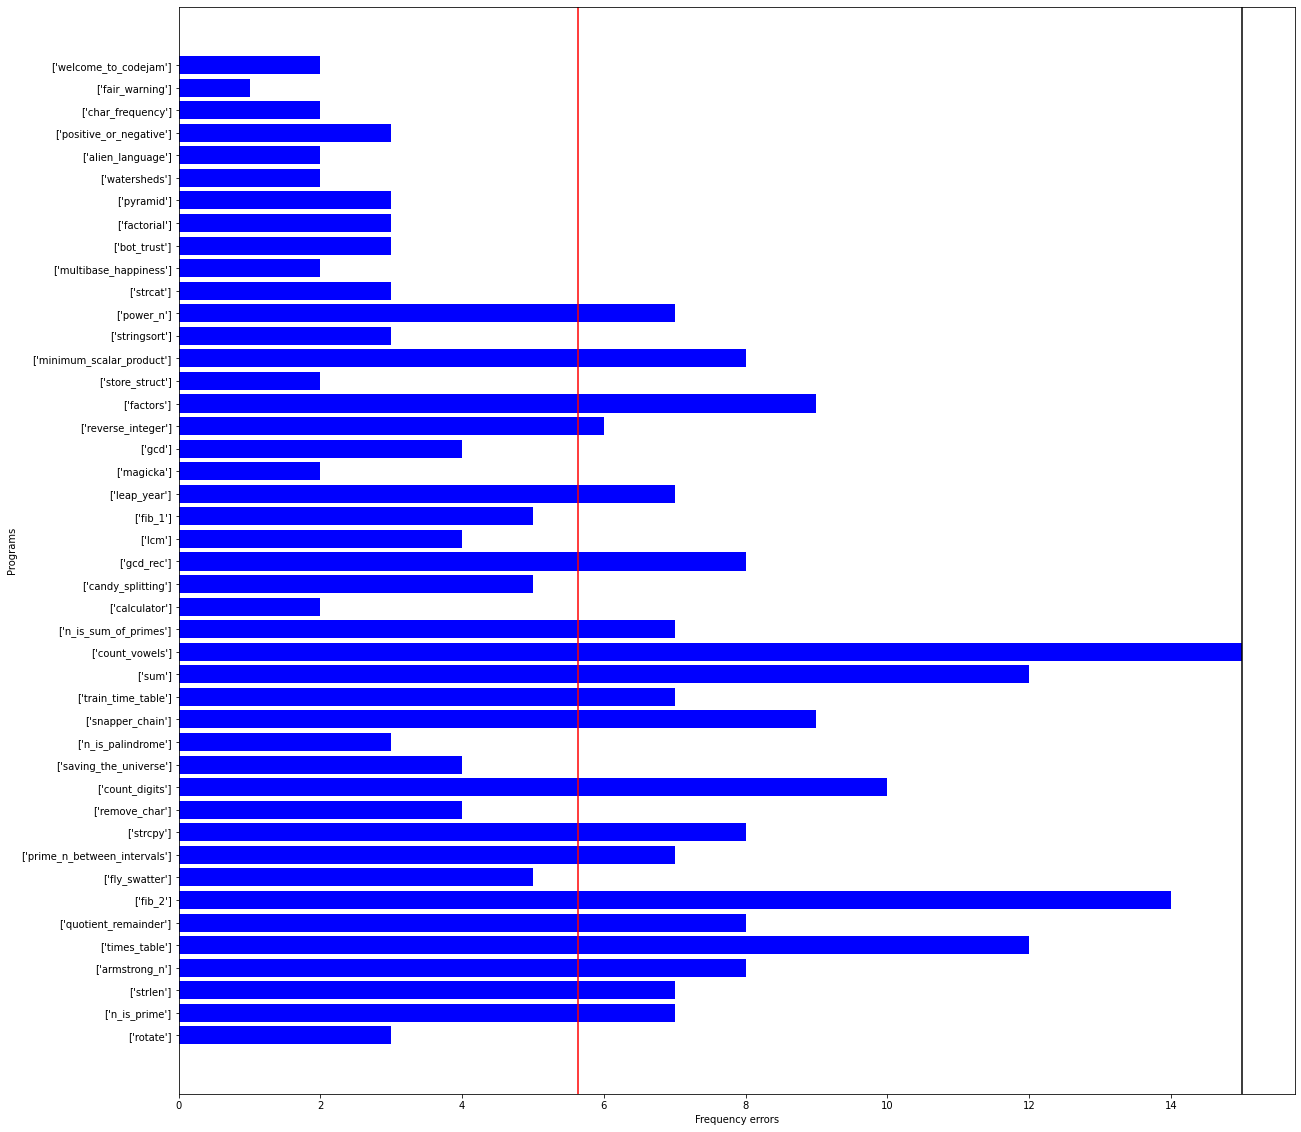


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


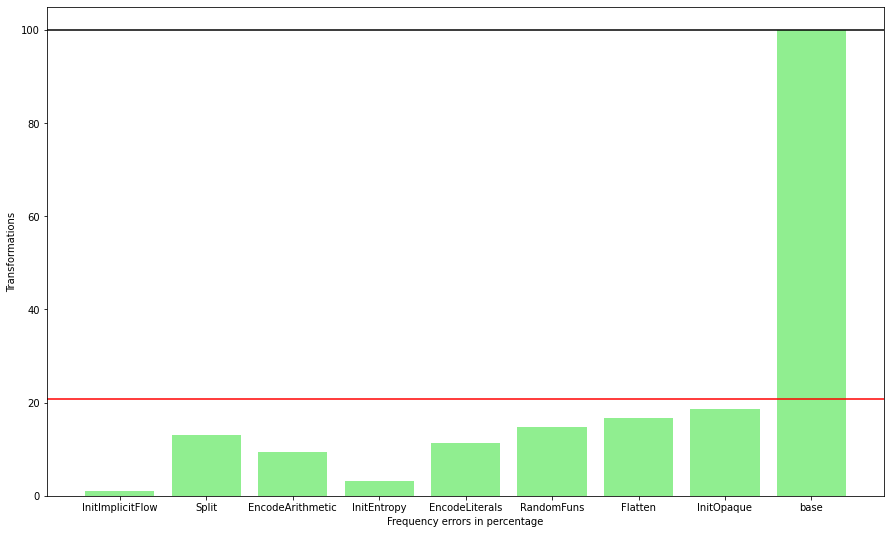

In [22]:
count_labels_err, count_obf_err, count_set_obfs, single_obf_percentage = my_lib.computing_incorrects_stats(modelVanilla2, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_obf_err, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_set_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_labels_err, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))

In [23]:
#Ordina e ritorna una lista
ordered_set_obfs = count_set_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-RandomFuns-Split', 33)
('EncodeLiterals-InitOpaque-Split', 31)
('EncodeLiterals-Flatten-Split', 18)
('EncodeArithmetic-RandomFuns-Split', 15)
('EncodeArithmetic-Flatten-Split', 15)
('EncodeLiterals-RandomFuns-Split', 10)
('EncodeLiterals-Flatten-InitOpaque', 10)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 10)
('Flatten-RandomFuns', 10)
('base', 9)
('EncodeArithmetic-EncodeLiterals-Split', 8)
('EncodeLiterals-InitOpaque-RandomFuns', 7)
('EncodeLiterals-InitEntropy-InitOpaque', 7)
('InitOpaque-RandomFuns', 7)
('EncodeLiterals-Flatten-RandomFuns', 7)
('EncodeArithmetic-InitEntropy-InitOpaque', 6)
('Flatten-InitOpaque-Split', 6)
('Flatten-InitOpaque', 6)
('EncodeArithmetic-EncodeLiterals-Flatten', 6)
('InitEntropy-InitOpaque-Split', 5)
('EncodeLiterals-InitImplicitFlow-InitOpaque', 5)
('EncodeArithmetic-InitOpaque', 4)
('InitOpaque-RandomFuns-Split', 3)
('EncodeArithmetic-InitEntropy-RandomFuns', 3)
('InitEntropy-RandomFuns', 2)
('EncodeLiterals-Flatten-InitImplicitFlow', 1)
(

#Confronti

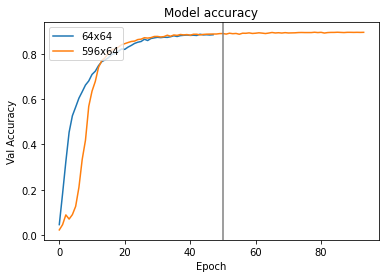

In [24]:
#Plot training & validation accuracy values
plt.plot(hist.history['val_acc'])
plt.plot(hist2.history['val_acc'])
plt.axvline(50, color="grey") # Horizontal line adding the threshold
plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['64x64', '596x64'], loc='upper left')
plt.show()